<a href="https://colab.research.google.com/github/VipulR2796/premier_league_results_prediction/blob/main/ML_Data_Cleaning_%26_Model_Building_Premier_League_Result_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MIT License

Copyright (c) 2022 Vipul Rajderkar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.



## Abstract:

Objective of this notebook is to perform exploratory data analysis on English Premier League data and build a model capable of predicting the winner amongst Home Team and Away Team for any particular match.



## Importing required libraries

In [236]:
#Importing all the libraries
!pip install fitter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

# Data Imputation
!pip install fancyimpute
from fancyimpute import IterativeImputer as MICE
from fancyimpute import KNN

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_tree, XGBRegressor
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif


import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [237]:
#Reading data from github
epl_data = pd.read_csv("https://raw.githubusercontent.com/VipulR2796/premier_league_results_prediction/main/df_full_premierleague.csv")

In [238]:
#Checking columns info
epl_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 114 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    Unnamed: 0                int64  
 1    link_match                object 
 2    season                    object 
 3    date                      object 
 4    home_team                 object 
 5    away_team                 object 
 6    result_full               object 
 7    result_ht                 object 
 8    home_clearances           float64
 9    home_corners              float64
 10   home_fouls_conceded       float64
 11   home_offsides             float64
 12   home_passes               float64
 13   home_possession           float64
 14   home_red_cards            float64
 15   home_shots                float64
 16   home_shots_on_target      float64
 17   home_tackles              float64
 18   home_touches              float64
 19   home_yellow_cards         float64
 20   away_c

## Importing data dictionary from Github

In [239]:
import base64
import requests

master = "https://raw.githubusercontent.com/VipulR2796/premier_league_results_prediction/main/data_dictionary.txt"
req = requests.get(master)
req = req.text
print(req)

link_match		: page link of match in Premier League Official website
season			: match season
date			: match date
home_team		: home team
away_team		: away team
result_full		: match result
result_ht		: match result in 1st time
home_clearances		: home team clearances in the match
home_corners		: home team corners in the match
home_fouls_conceded	: home team fouls conceded in the match
home_offsides		: home team offsides in the match
home_passes		: home team passes in the match
home_possession		: home team possession in the match
home_red_cards		: home team red cards in the match
home_shots		: home team shots in the match
home_shots_on_target	: home team shots on target in the match
home_tackles		: home team tackles in the match
home_touches		: home team touches in the match
home_yellow_cards	: home team yellow cards in the match
away_clearances		: away tem clearances in the match
away_corners		: away team corners in the match
away_fouls_conceded	: away team fouls conceded in the match
away

## There are 2 types of stats data availables:
1. **Pre Match Data** - Focuses on average performance of specific team until last match in an ongoing season. These performance KPIs varies from attacking strength, defense strength, conversion rates etc.

2. **Post Match Data** - Provides insights/values on particular match stats. 

### **Objective** : Predict the winning team for an upcoming match basis average performance of both teams until their last matches. ***To do so, pre match analysis data has to be used and post match data can be dropped.***


In [240]:
 # Making a copy/backup of the dataset
data = epl_data.copy(deep=True)

# Remove all columns between column index 1 to 3
data.drop(data.loc[:, 'home_clearances': 'sg_match_ht'], inplace=True, axis=1)


In [241]:
data.drop(columns = ['Unnamed: 0', 'link_match', 'date'], inplace = True)

# Creating a target colum Winner - Winner can be 'Home Team', 'Away Team', 'Draw'
data['Winner'] = data['result_full'].apply(lambda x: 'Home' if int(x.split("-")[0]) > int(x.split("-")[1]) else "Away" if int(x.split("-")[0]) < int(x.split("-")[1]) else "Draw")

# Current match score is not required
data.drop(columns = ['result_full', 'result_ht'], inplace=True)

# Dropping additional columns which are not required
data.drop(data.loc[:, 'clearances_avg_home': 'performance_acum_away'], inplace=True, axis=1)
data.info(verbose=True)
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070 entries, 0 to 4069
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   season                 4070 non-null   object 
 1   home_team              4070 non-null   object 
 2   away_team              4070 non-null   object 
 3   clearances_avg_H       3850 non-null   float64
 4   corners_avg_H          3850 non-null   float64
 5   fouls_conceded_avg_H   3850 non-null   float64
 6   offsides_avg_H         3850 non-null   float64
 7   passes_avg_H           3850 non-null   float64
 8   possession_avg_H       3850 non-null   float64
 9   red_cards_avg_H        3850 non-null   float64
 10  shots_avg_H            3850 non-null   float64
 11  shots_on_target_avg_H  3850 non-null   float64
 12  tackles_avg_H          3850 non-null   float64
 13  touches_avg_H          3850 non-null   float64
 14  yellow_cards_avg_H     3850 non-null   float64
 15  goal

season                     0
home_team                  0
away_team                  0
clearances_avg_H         220
corners_avg_H            220
fouls_conceded_avg_H     220
offsides_avg_H           220
passes_avg_H             220
possession_avg_H         220
red_cards_avg_H          220
shots_avg_H              220
shots_on_target_avg_H    220
tackles_avg_H            220
touches_avg_H            220
yellow_cards_avg_H       220
goals_scored_ft_avg_H    220
goals_conced_ft_avg_H    220
sg_match_ft_acum_H       220
goals_scored_ht_avg_H    220
goals_conced_ht_avg_H    220
sg_match_ht_acum_H       220
performance_acum_H       220
clearances_avg_A         220
corners_avg_A            220
fouls_conceded_avg_A     220
offsides_avg_A           220
passes_avg_A             220
possession_avg_A         220
red_cards_avg_A          220
shots_avg_A              220
shots_on_target_avg_A    220
tackles_avg_A            220
touches_avg_A            220
yellow_cards_avg_A       220
goals_scored_f

####***Q1:  What are the data types? => Categorical and Numeric***



#### **Q2:  Are there missing values?**
#### **Q5. Which independent variables have missing data? How much? **
         All the numeric columns have 220 missing values.

## Exploratory Data Analysis

### **Distributions of Numeric/Predictor Variables**

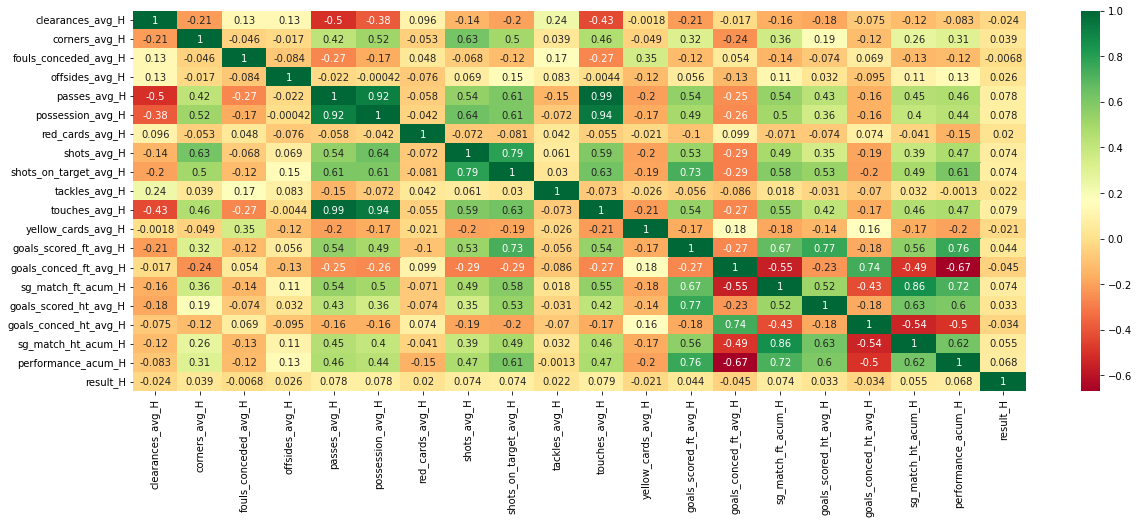

In [242]:
# List of numeric columns

# Creating a numeric result column for home and away teams (1: win, 0: loss, 2:draw)
data['result_H'] = data['Winner'].apply(lambda x: 1 if x == 'Home' else 0 if x == 'Away' else 2)
data['result_A'] = data['Winner'].apply(lambda x: 0 if x == 'Home' else 1 if x == 'Away' else 2)
home_num_cols = [x for x in list(data.columns) if (data[x].dtype == float or data[x].dtype == int) and '_H' in x]
away_num_cols = [x for x in list(data.columns) if (data[x].dtype == float or data[x].dtype == int) and '_A' in x]

home_num_col_data = data[home_num_cols]
away_num_col_data = data[away_num_cols]

#the heat map of the correlation
# plt.title("Correlation between Home Team KPIs")
plt.figure(figsize=(20,7))
sns.heatmap(home_num_col_data.corr(), annot=True, cmap='RdYlGn')
# plt.show

#### **Q7. In the predictor variables independent of all the other predictor variables?** - Above plot explains collinearity

#### **Q3. What are the likely distributions of the numeric variables?** - Distribution Plots are as follows:


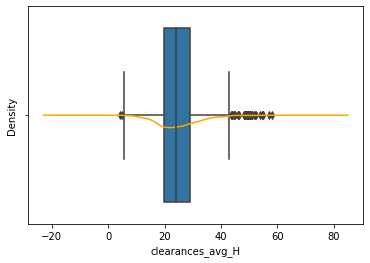

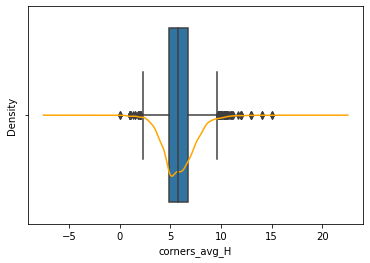

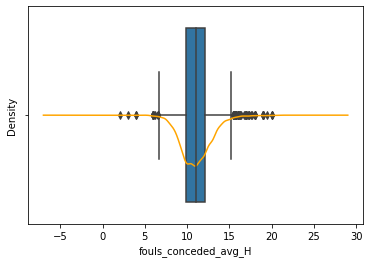

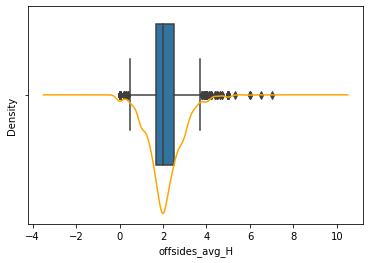

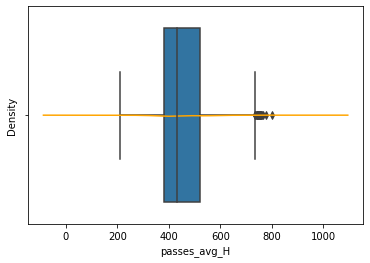

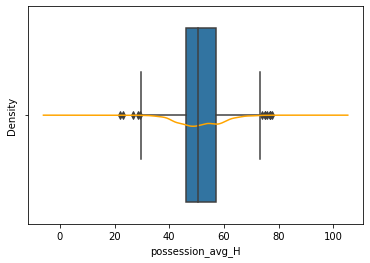

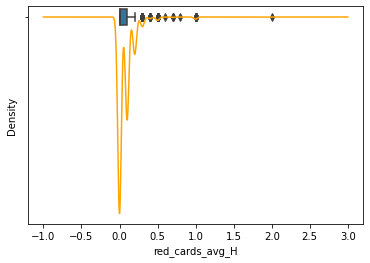

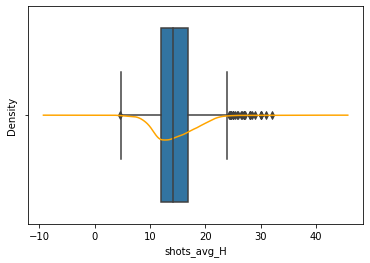

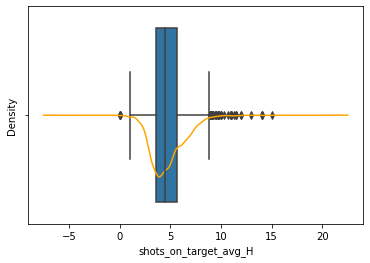

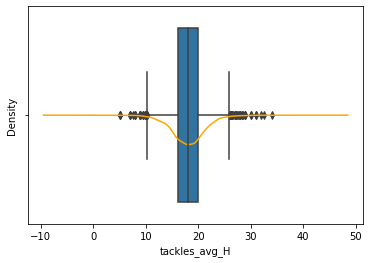

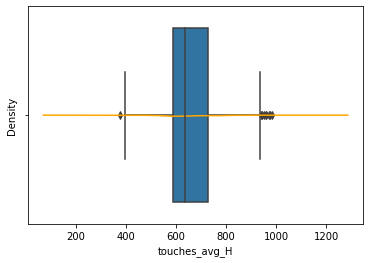

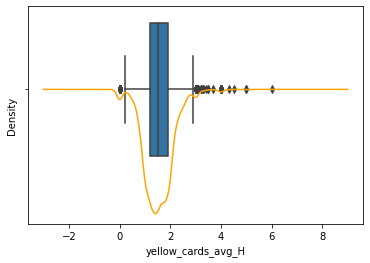

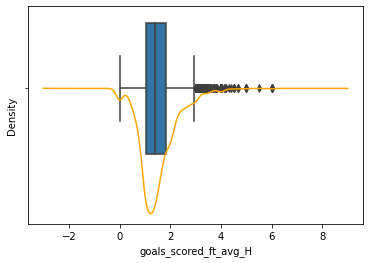

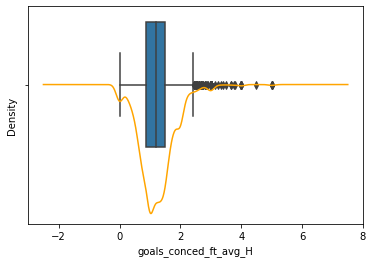

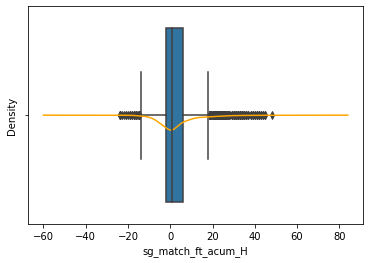

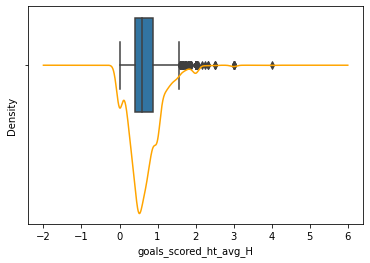

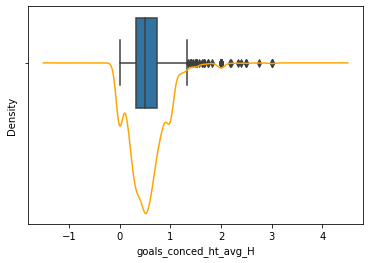

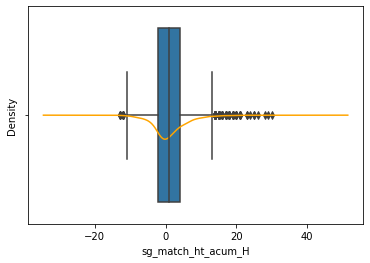

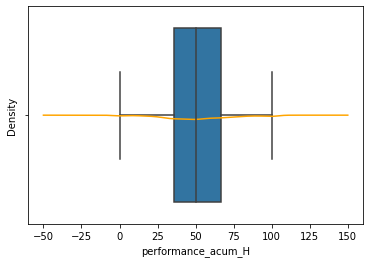

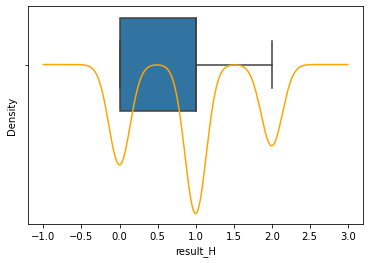

In [243]:
# Plotting the distribution of home team stats


for col in home_num_cols:
  sns.boxplot(x=data[col])
  
  data[col].plot.density(color="Orange")
  plt.xlabel(col)
  plt.show()

     

From all the above graphs, it is clear that all the numeric values are distributed normally. (result_H can have only 3 values 0, 1 or 2 )

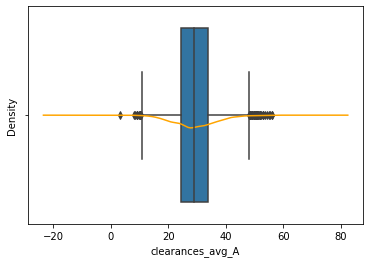

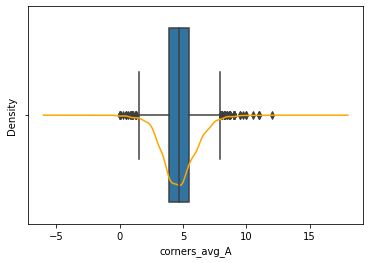

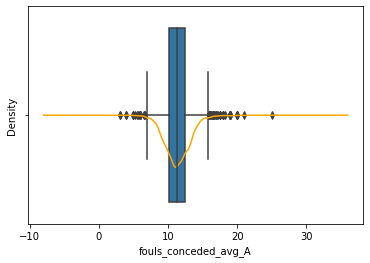

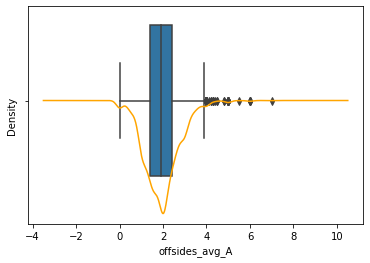

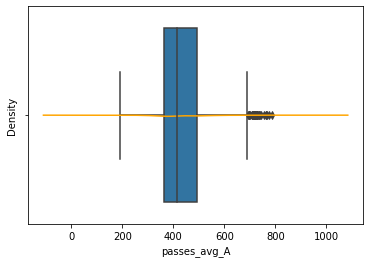

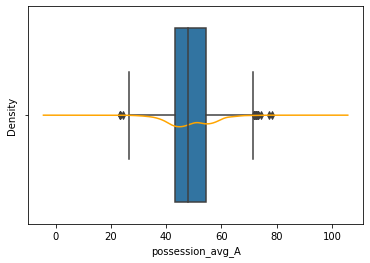

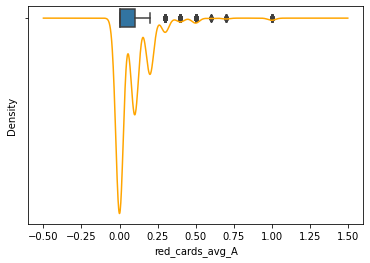

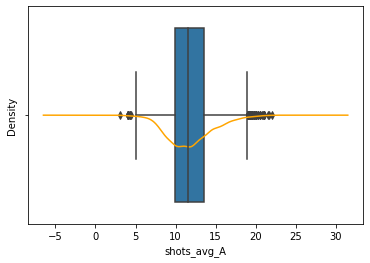

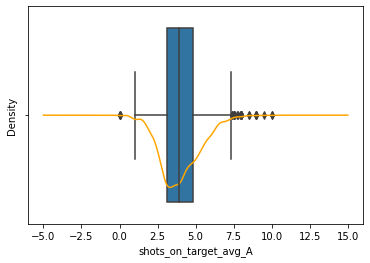

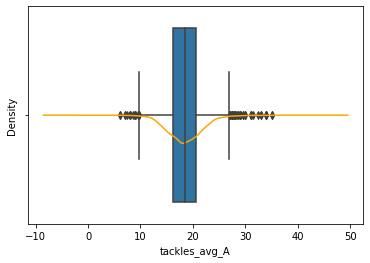

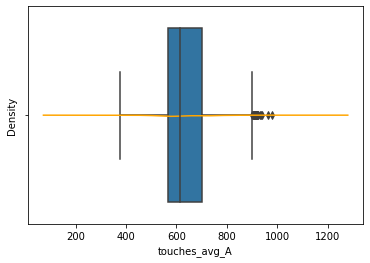

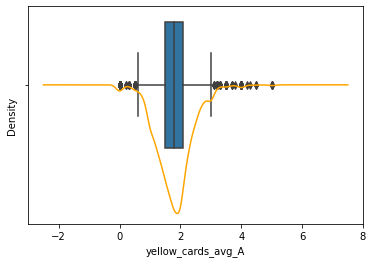

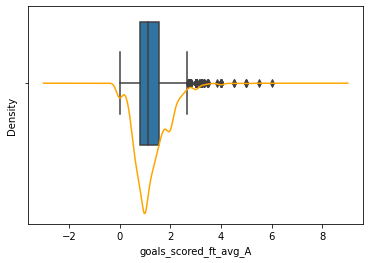

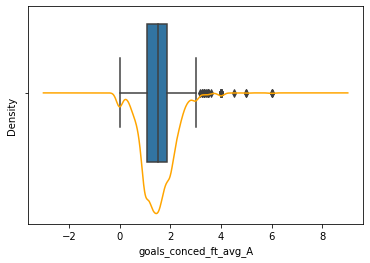

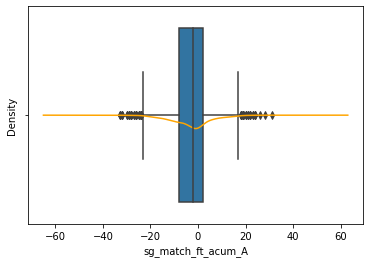

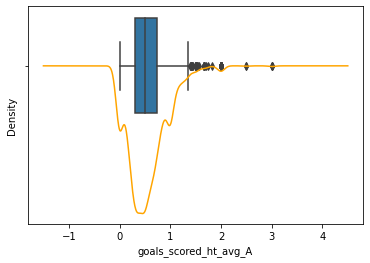

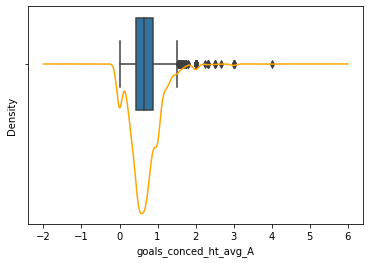

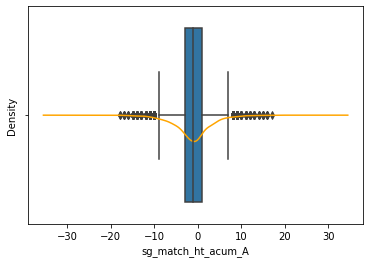

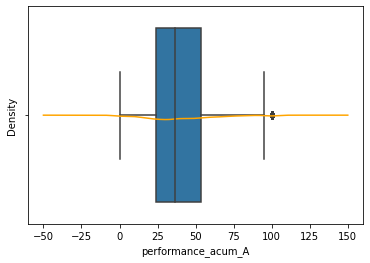

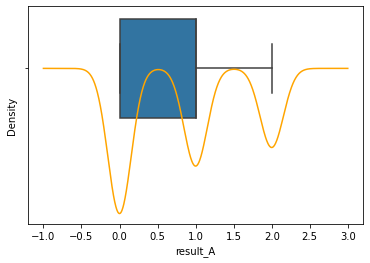

In [244]:
# Plotting the distribution of away team stats

for col in away_num_cols:
  sns.boxplot(x=data[col])
  
  data[col].plot.density(color="Orange")
  plt.xlabel(col)
  plt.show()
  

In [245]:
# sns.pairplot(data)

***Dataset has total 114 columns out of which 100 are of type Float, 7 are of type Int and remaining 7 are of type Object***

In [246]:
data.isna().sum()

season                     0
home_team                  0
away_team                  0
clearances_avg_H         220
corners_avg_H            220
fouls_conceded_avg_H     220
offsides_avg_H           220
passes_avg_H             220
possession_avg_H         220
red_cards_avg_H          220
shots_avg_H              220
shots_on_target_avg_H    220
tackles_avg_H            220
touches_avg_H            220
yellow_cards_avg_H       220
goals_scored_ft_avg_H    220
goals_conced_ft_avg_H    220
sg_match_ft_acum_H       220
goals_scored_ht_avg_H    220
goals_conced_ht_avg_H    220
sg_match_ht_acum_H       220
performance_acum_H       220
clearances_avg_A         220
corners_avg_A            220
fouls_conceded_avg_A     220
offsides_avg_A           220
passes_avg_A             220
possession_avg_A         220
red_cards_avg_A          220
shots_avg_A              220
shots_on_target_avg_A    220
tackles_avg_A            220
touches_avg_A            220
yellow_cards_avg_A       220
goals_scored_f

***Data has 114 columns. Many of which are not required for redicting specific match's score and hence can be dropped***

### Creating Target Column

In [247]:
data['Winner'] = data[['result_H', 'result_A']].apply(lambda row: "Home" if row['result_H'] > row['result_A'] else "Away" if row['result_H'] < row['result_A'] else "Draw" if row['result_H']==row['result_A'] else "NA", axis=1)
data.head()

,season,home_team,away_team,clearances_avg_H,corners_avg_H,fouls_conceded_avg_H,offsides_avg_H,passes_avg_H,possession_avg_H,red_cards_avg_H,...,goals_scored_ft_avg_A,goals_conced_ft_avg_A,sg_match_ft_acum_A,goals_scored_ht_avg_A,goals_conced_ht_avg_A,sg_match_ht_acum_A,performance_acum_A,Winner,result_H,result_A
0,10/11,Blackpool,West Bromwich Albion,41.0,5.0,11.7,3.7,453.7,56.2,0.0,...,1.25,2.75,-6.0,0.00,1.00,-4.0,33.3,Home,1,0
1,10/11,Liverpool,Manchester City,28.8,6.7,12.3,2.7,434.7,52.3,0.1,...,1.47,1.07,6.0,0.80,0.27,8.0,48.9,Home,1,0
2,10/11,Manchester United,Arsenal,20.0,5.4,9.5,2.8,540.9,58.4,0.0,...,1.88,1.00,7.0,0.88,0.25,5.0,70.8,Home,1,0
3,10/11,Stoke City,Aston Villa,17.0,6.0,15.0,2.0,317.0,41.7,0.0,...,0.00,6.00,-6.0,0.00,3.00,-3.0,0.0,Home,1,0
4,10/11,Fulham,Chelsea,36.8,5.3,11.7,3.0,475.5,54.0,0.0,...,1.69,1.08,8.0,0.69,0.77,-1.0,46.2,Draw,2,2


##Data Imputation


In [248]:

#finding % of missing data in dataset
for col in list(data.columns):
  print(
      "Percent of Missing Data in {} Coloumn = {}%".format(col, str((data[col].isnull().sum() / len(data)) * 100))
      
  )

  # Storing column names having null values
  cols_having_null = [col for col in list(data.columns) if data[col].isnull().sum() != 0]

Percent of Missing Data in season Coloumn = 0.0%
Percent of Missing Data in home_team Coloumn = 0.0%
Percent of Missing Data in away_team Coloumn = 0.0%
Percent of Missing Data in clearances_avg_H Coloumn = 5.405405405405405%
Percent of Missing Data in corners_avg_H Coloumn = 5.405405405405405%
Percent of Missing Data in fouls_conceded_avg_H Coloumn = 5.405405405405405%
Percent of Missing Data in offsides_avg_H Coloumn = 5.405405405405405%
Percent of Missing Data in passes_avg_H Coloumn = 5.405405405405405%
Percent of Missing Data in possession_avg_H Coloumn = 5.405405405405405%
Percent of Missing Data in red_cards_avg_H Coloumn = 5.405405405405405%
Percent of Missing Data in shots_avg_H Coloumn = 5.405405405405405%
Percent of Missing Data in shots_on_target_avg_H Coloumn = 5.405405405405405%
Percent of Missing Data in tackles_avg_H Coloumn = 5.405405405405405%
Percent of Missing Data in touches_avg_H Coloumn = 5.405405405405405%
Percent of Missing Data in yellow_cards_avg_H Coloumn = 

In [249]:
data.shape

(4070, 44)

 So there are 44 columns in a dataset. We will move ahead with all these columns and identify variable significance in a later stage

 Next task is to imput null values

### KNN Method


In [250]:
 # Initializing objects
encoder = OrdinalEncoder()
imputer = KNN()

In [251]:
# Categorical or Numerical Coloumns
categorical_columns = [
    col for col in data.columns if data[col].dtype == "object"
]
print("Categorical Columns : ", categorical_columns)

categorical_columns = list(set(categorical_columns))

numerical_columns = [col for col in data.columns if col not in categorical_columns]
print("Numerical Columns : ", numerical_columns)

Categorical Columns :  ['season', 'home_team', 'away_team', 'Winner']
Numerical Columns :  ['clearances_avg_H', 'corners_avg_H', 'fouls_conceded_avg_H', 'offsides_avg_H', 'passes_avg_H', 'possession_avg_H', 'red_cards_avg_H', 'shots_avg_H', 'shots_on_target_avg_H', 'tackles_avg_H', 'touches_avg_H', 'yellow_cards_avg_H', 'goals_scored_ft_avg_H', 'goals_conced_ft_avg_H', 'sg_match_ft_acum_H', 'goals_scored_ht_avg_H', 'goals_conced_ht_avg_H', 'sg_match_ht_acum_H', 'performance_acum_H', 'clearances_avg_A', 'corners_avg_A', 'fouls_conceded_avg_A', 'offsides_avg_A', 'passes_avg_A', 'possession_avg_A', 'red_cards_avg_A', 'shots_avg_A', 'shots_on_target_avg_A', 'tackles_avg_A', 'touches_avg_A', 'yellow_cards_avg_A', 'goals_scored_ft_avg_A', 'goals_conced_ft_avg_A', 'sg_match_ft_acum_A', 'goals_scored_ht_avg_A', 'goals_conced_ht_avg_A', 'sg_match_ht_acum_A', 'performance_acum_A', 'result_H', 'result_A']


In [252]:
data_with_nulls = data.copy(deep=True)
knn_impute_df = data.copy(deep=True)

# None of the categorical features have null values; hence applying KNN imputation on numeric columns only
knn_impute_numerical_df = pd.DataFrame(
        (imputer.fit_transform(data_with_nulls[numerical_columns])), columns=numerical_columns
    )


knn_impute_df[numerical_columns] = knn_impute_numerical_df

Imputing row 1/4070 with 0 missing, elapsed time: 10.955
Imputing row 101/4070 with 0 missing, elapsed time: 10.966
Imputing row 201/4070 with 0 missing, elapsed time: 10.975
Imputing row 301/4070 with 0 missing, elapsed time: 10.980
Imputing row 401/4070 with 0 missing, elapsed time: 10.983
Imputing row 501/4070 with 38 missing, elapsed time: 10.995
Imputing row 601/4070 with 0 missing, elapsed time: 10.998
Imputing row 701/4070 with 0 missing, elapsed time: 11.004
Imputing row 801/4070 with 0 missing, elapsed time: 11.008
Imputing row 901/4070 with 0 missing, elapsed time: 11.016
Imputing row 1001/4070 with 0 missing, elapsed time: 11.024
Imputing row 1101/4070 with 0 missing, elapsed time: 11.030
Imputing row 1201/4070 with 0 missing, elapsed time: 11.034
Imputing row 1301/4070 with 0 missing, elapsed time: 11.053
Imputing row 1401/4070 with 0 missing, elapsed time: 11.054
Imputing row 1501/4070 with 0 missing, elapsed time: 11.060
Imputing row 1601/4070 with 0 missing, elapsed time

In [253]:
# Checking if entries are imputed
print(data.isnull().sum())
print("\nAfter Imputing the Data\n")
print(knn_impute_df.isnull().sum())

season                     0
home_team                  0
away_team                  0
clearances_avg_H         220
corners_avg_H            220
fouls_conceded_avg_H     220
offsides_avg_H           220
passes_avg_H             220
possession_avg_H         220
red_cards_avg_H          220
shots_avg_H              220
shots_on_target_avg_H    220
tackles_avg_H            220
touches_avg_H            220
yellow_cards_avg_H       220
goals_scored_ft_avg_H    220
goals_conced_ft_avg_H    220
sg_match_ft_acum_H       220
goals_scored_ht_avg_H    220
goals_conced_ht_avg_H    220
sg_match_ht_acum_H       220
performance_acum_H       220
clearances_avg_A         220
corners_avg_A            220
fouls_conceded_avg_A     220
offsides_avg_A           220
passes_avg_A             220
possession_avg_A         220
red_cards_avg_A          220
shots_avg_A              220
shots_on_target_avg_A    220
tackles_avg_A            220
touches_avg_A            220
yellow_cards_avg_A       220
goals_scored_f

### Mean & Mode Method

------- UnImputed vs Imputed for clearances_avg_H -------


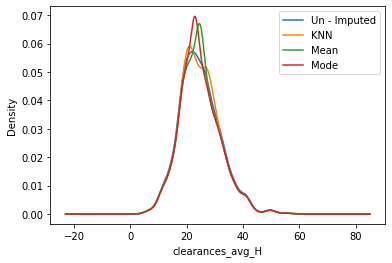

------- UnImputed vs Imputed for corners_avg_H -------


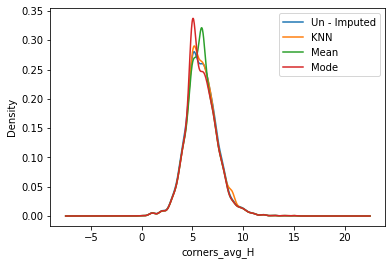

------- UnImputed vs Imputed for fouls_conceded_avg_H -------


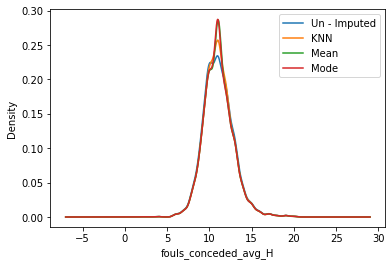

------- UnImputed vs Imputed for offsides_avg_H -------


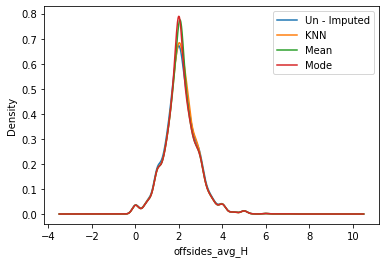

------- UnImputed vs Imputed for passes_avg_H -------


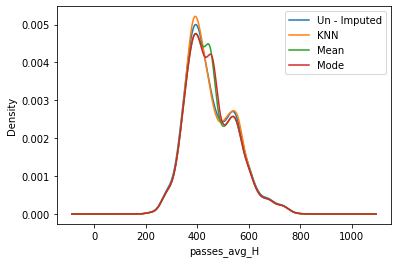

------- UnImputed vs Imputed for possession_avg_H -------


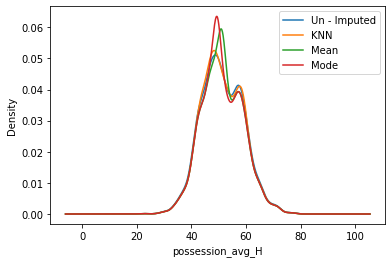

------- UnImputed vs Imputed for red_cards_avg_H -------


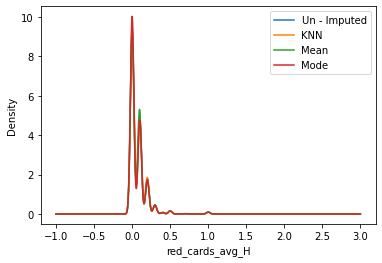

------- UnImputed vs Imputed for shots_avg_H -------


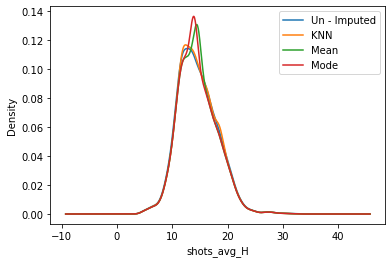

------- UnImputed vs Imputed for shots_on_target_avg_H -------


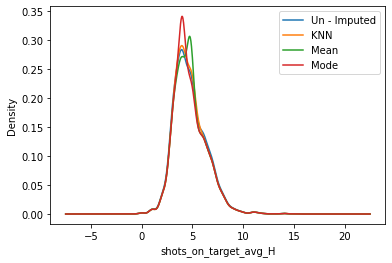

------- UnImputed vs Imputed for tackles_avg_H -------


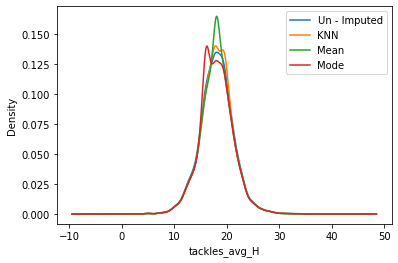

------- UnImputed vs Imputed for touches_avg_H -------


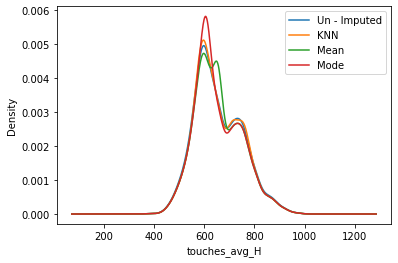

------- UnImputed vs Imputed for yellow_cards_avg_H -------


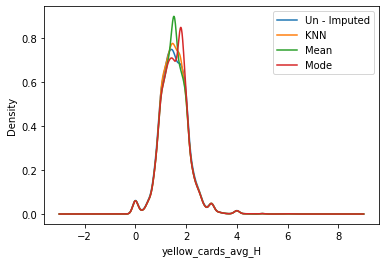

------- UnImputed vs Imputed for goals_scored_ft_avg_H -------


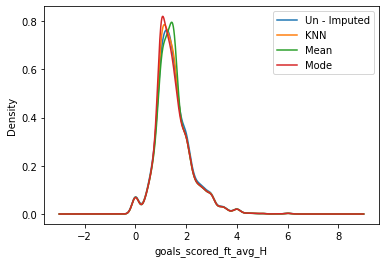

------- UnImputed vs Imputed for goals_conced_ft_avg_H -------


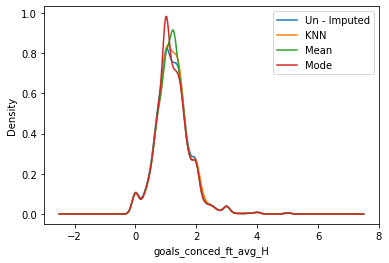

------- UnImputed vs Imputed for sg_match_ft_acum_H -------


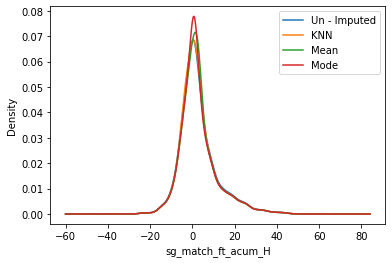

------- UnImputed vs Imputed for goals_scored_ht_avg_H -------


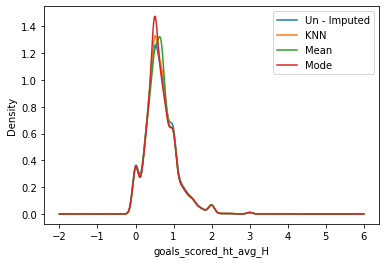

------- UnImputed vs Imputed for goals_conced_ht_avg_H -------


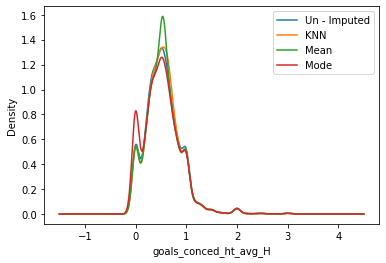

------- UnImputed vs Imputed for sg_match_ht_acum_H -------


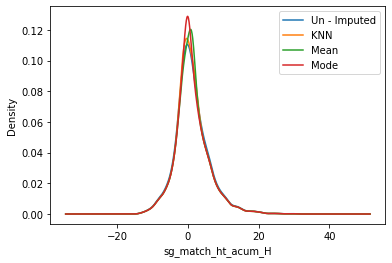

------- UnImputed vs Imputed for performance_acum_H -------


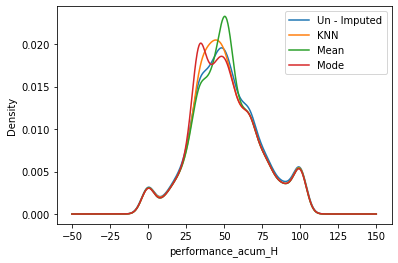

------- UnImputed vs Imputed for clearances_avg_A -------


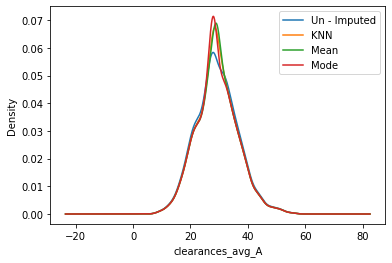

------- UnImputed vs Imputed for corners_avg_A -------


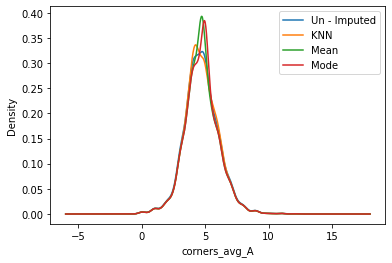

------- UnImputed vs Imputed for fouls_conceded_avg_A -------


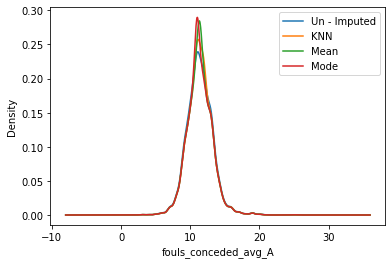

------- UnImputed vs Imputed for offsides_avg_A -------


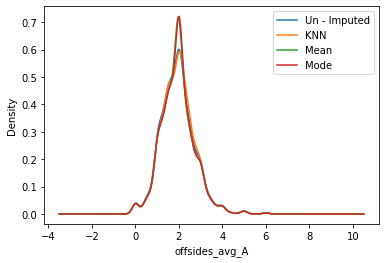

------- UnImputed vs Imputed for passes_avg_A -------


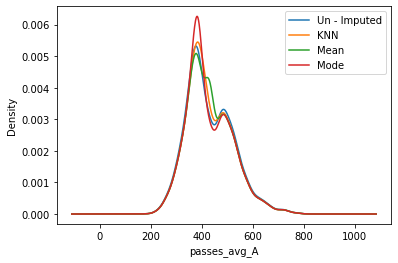

------- UnImputed vs Imputed for possession_avg_A -------


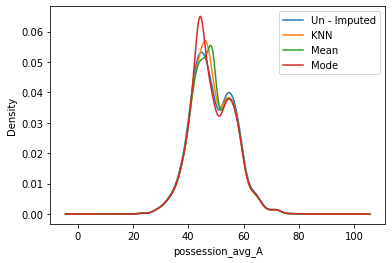

------- UnImputed vs Imputed for red_cards_avg_A -------


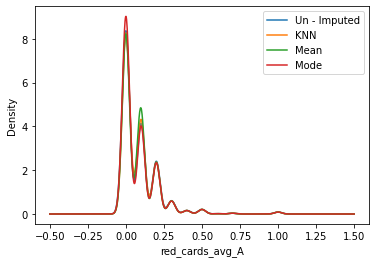

------- UnImputed vs Imputed for shots_avg_A -------


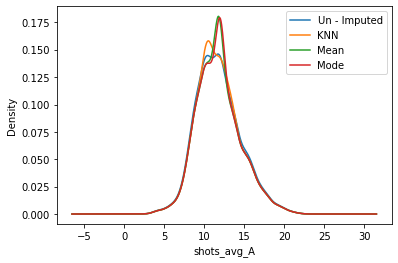

------- UnImputed vs Imputed for shots_on_target_avg_A -------


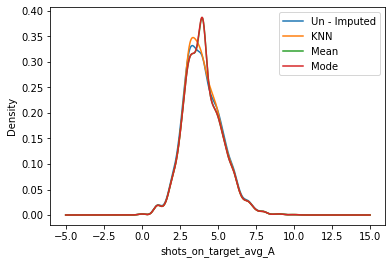

------- UnImputed vs Imputed for tackles_avg_A -------


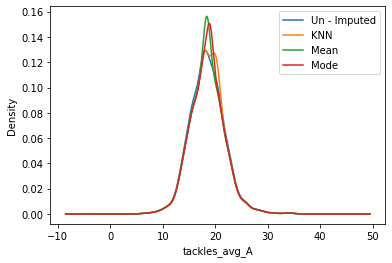

------- UnImputed vs Imputed for touches_avg_A -------


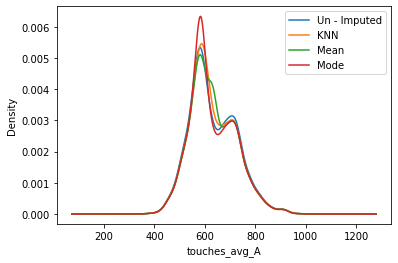

------- UnImputed vs Imputed for yellow_cards_avg_A -------


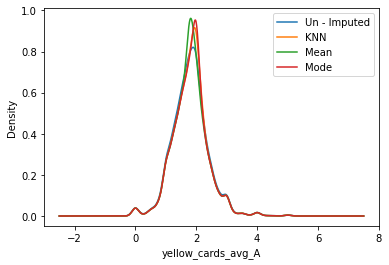

------- UnImputed vs Imputed for goals_scored_ft_avg_A -------


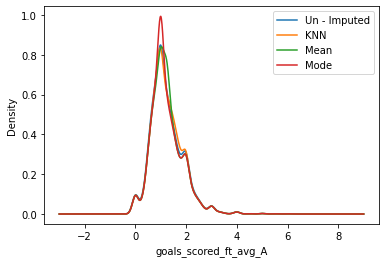

------- UnImputed vs Imputed for goals_conced_ft_avg_A -------


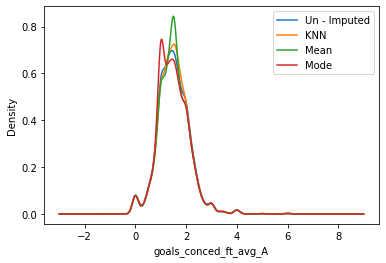

------- UnImputed vs Imputed for sg_match_ft_acum_A -------


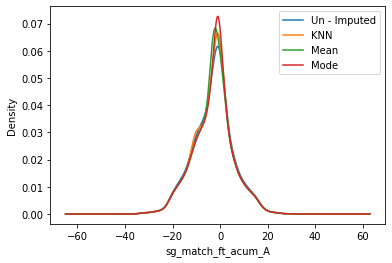

------- UnImputed vs Imputed for goals_scored_ht_avg_A -------


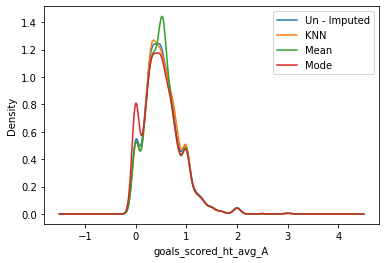

------- UnImputed vs Imputed for goals_conced_ht_avg_A -------


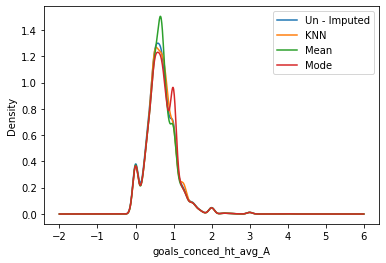

------- UnImputed vs Imputed for sg_match_ht_acum_A -------


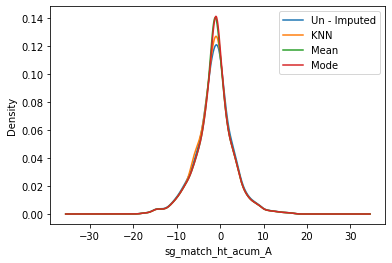

------- UnImputed vs Imputed for performance_acum_A -------


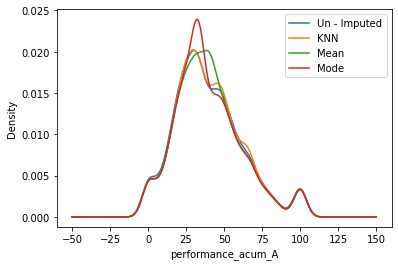

------- UnImputed vs Imputed for result_H -------


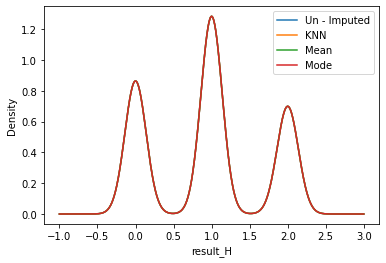

------- UnImputed vs Imputed for result_A -------


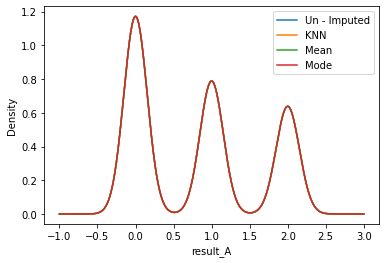

In [254]:

# Statistical Difference in columns having null values after KNN Imputation
# Mean
mean_impute_df = data.copy(deep=True)
# Median
median_impute_df = data.copy(deep=True)

for col in list(numerical_columns):

  
  mean_impute_df[col] = mean_impute_df[col].fillna(mean_impute_df[col].mean() )
  median_impute_df[col] = median_impute_df[col].fillna(median_impute_df[col].mode()[0])

  print("------- UnImputed vs Imputed for {} -------".format(col))
  data[col].plot(kind="kde")
  knn_impute_df[col].plot(kind="kde")
  mean_impute_df[col].plot(kind="kde")
  median_impute_df[col].plot(kind="kde")

  plt.legend(["Un - Imputed", "KNN", "Mean", "Mode"])
  plt.xlabel(col)
  plt.show()
  

As observed in above plots, KNN works better than Mean and Mode methods and hence we will use KNN impoutation for entire dataset

## Encoding Target Variable

Target Variable contains Following Values: "H", "A" or "D"

We need to conert this values into numbers 0, 1 and 2

In [255]:
# Applying label encoding to target variable
le = preprocessing.LabelEncoder()

knn_impute_df['Winner'] = le.fit_transform(knn_impute_df['Winner'])

le.classes_

array(['Away', 'Draw', 'Home'], dtype=object)

## Feature Selection

#### **Q4. Which independent variables are useful to predict a target (dependent variable)? (Use at least three methods):** We will apply 3 feature selection methods on a dataset to reduce its dimentionality

### 1. Chi Square Method for categorical features

In [256]:
from scipy.stats import chi2_contingency
# import pandas as pd

# Load the data into a pandas DataFrame
# df = pd.read_csv('your_data.csv')

# # Define the two categorical columns you want to test
col1 = 'away_team'
col2 = 'Winner'

# Create a contingency table from the two columns
ctab = pd.crosstab(data[col1], data[col2])

# Perform the chi-square test of independence
chi2, p, dof, expected = chi2_contingency(ctab)

p
# Check the p-value to determine the significance of the test

if p < 0.05:
    print(f'The association between {col1} and {col2} is significant (p = {p:.4f})')
else:
    print(f'The association between {col1} and {col2} is not significant (p = {p:.4f})')

The association between away_team and Winner is significant (p = 0.0000)


### 2. Annova Test for Numerical Features

In [257]:
sk = SelectKBest(k = 'all')
# num_cols = 
numerical_df = knn_impute_df[numerical_columns]
sk.fit_transform(numerical_df, knn_impute_df['Winner'])

array([[41. ,  5. , 11.7, ..., 33.3,  1. ,  0. ],
       [28.8,  6.7, 12.3, ..., 48.9,  1. ,  0. ],
       [20. ,  5.4,  9.5, ..., 70.8,  1. ,  0. ],
       ...,
       [17.8,  4. , 10.4, ..., 74.4,  2. ,  2. ],
       [18.6,  4.9, 11.7, ..., 59. ,  1. ,  0. ],
       [24.3,  4. , 10.6, ..., 47.6,  2. ,  2. ]])

In [258]:
cols_to_be_removed = []
for i in range(len(sk.scores_)):
	print((numerical_columns[i], sk.scores_[i]))
  

('clearances_avg_H', 29.097089518432124)
('corners_avg_H', 71.05836309935488)
('fouls_conceded_avg_H', 2.7355059520906737)
('offsides_avg_H', 5.430688227918874)
('passes_avg_H', 132.43628645393196)
('possession_avg_H', 112.50819168627682)
('red_cards_avg_H', 4.841830202768323)
('shots_avg_H', 130.2612345015155)
('shots_on_target_avg_H', 133.66908125473088)
('tackles_avg_H', 1.3524839015180972)
('touches_avg_H', 134.5886316734132)
('yellow_cards_avg_H', 8.62728044807268)
('goals_scored_ft_avg_H', 98.72570871438519)
('goals_conced_ft_avg_H', 30.164665598744612)
('sg_match_ft_acum_H', 132.05796782537612)
('goals_scored_ht_avg_H', 49.4946334233841)
('goals_conced_ht_avg_H', 32.116759152212694)
('sg_match_ht_acum_H', 95.00105969197413)
('performance_acum_H', 76.0806267611444)
('clearances_avg_A', 31.088153793812946)
('corners_avg_A', 89.23592072305567)
('fouls_conceded_avg_A', 5.44416995123824)
('offsides_avg_A', 3.3197680853749345)
('passes_avg_A', 111.3153944021963)
('possession_avg_A', 9

In [259]:
sixty_percentile = np.percentile(sk.scores_, 60)
sixty_percentile

83.8418161295608

In [260]:
cols_to_be_removed = []
for i in range(len(sk.scores_)):
  if sk.scores_[i] < sixty_percentile:
    cols_to_be_removed.append(numerical_columns[i])

cols_to_be_removed

['clearances_avg_H',
 'corners_avg_H',
 'fouls_conceded_avg_H',
 'offsides_avg_H',
 'red_cards_avg_H',
 'tackles_avg_H',
 'yellow_cards_avg_H',
 'goals_conced_ft_avg_H',
 'goals_scored_ht_avg_H',
 'goals_conced_ht_avg_H',
 'performance_acum_H',
 'clearances_avg_A',
 'fouls_conceded_avg_A',
 'offsides_avg_A',
 'red_cards_avg_A',
 'tackles_avg_A',
 'yellow_cards_avg_A',
 'goals_scored_ft_avg_A',
 'goals_conced_ft_avg_A',
 'sg_match_ft_acum_A',
 'goals_scored_ht_avg_A',
 'goals_conced_ht_avg_A',
 'sg_match_ht_acum_A',
 'performance_acum_A']

So, all the above columns have scores less than 60 percentile and hence can be dropped to reduce dimentionality

In [261]:
knn_impute_df.drop(columns = cols_to_be_removed, inplace=True)

In [262]:
knn_impute_df.shape

(4070, 20)

### 3. Mutual Info Test

In [263]:
sk = SelectKBest(k = 'all' , score_func = mutual_info_classif)

In [264]:
new_num_cols = [x for x in numerical_columns if x in list(knn_impute_df.columns)]
sk.fit_transform(knn_impute_df[new_num_cols], knn_impute_df['Winner'])

for i in range(len(sk.scores_)):
	print((new_num_cols[i], sk.scores_[i]))

('passes_avg_H', 0.07029837799365901)
('possession_avg_H', 0.09549398634087902)
('shots_avg_H', 0.08383789025525146)
('shots_on_target_avg_H', 0.08693067887764028)
('touches_avg_H', 0.07436602732490383)
('goals_scored_ft_avg_H', 0.06699323939124979)
('sg_match_ft_acum_H', 0.07455405008661198)
('sg_match_ht_acum_H', 0.06166493058311473)
('corners_avg_A', 0.05401825004193839)
('passes_avg_A', 0.07946310604320628)
('possession_avg_A', 0.07843358515348631)
('shots_avg_A', 0.07674300734546691)
('shots_on_target_avg_A', 0.0898968698362046)
('touches_avg_A', 0.09346736995225435)
('result_H', 1.066149364106773)
('result_A', 1.066395064352473)


In [265]:
sixty_percentile_mti = np.percentile(sk.scores_, 40)
sixty_percentile_mti

0.07674300734546691

In [266]:
cols_to_be_removed = []
for i in range(len(sk.scores_)):
  if sk.scores_[i] < sixty_percentile_mti:
    cols_to_be_removed.append(new_num_cols[i])

cols_to_be_removed

['passes_avg_H',
 'touches_avg_H',
 'goals_scored_ft_avg_H',
 'sg_match_ft_acum_H',
 'sg_match_ht_acum_H',
 'corners_avg_A']

In [267]:
# All the above columns has score less than 40th percentile and hence can be dropped
knn_impute_df.drop(columns = cols_to_be_removed, inplace=True)

In [268]:
knn_impute_df.shape

(4070, 14)

In [269]:
cat_features = list(set(categorical_columns) - set(['Winner']))
print(cat_features)
for cat_col in cat_features:
  encoding = knn_impute_df.groupby(cat_col)['Winner'].mean()

  # Map the mean back to the original data
  knn_impute_df[cat_col+'_encoded'] = knn_impute_df[cat_col].map(encoding)

knn_impute_df.head()

['home_team', 'season', 'away_team']


,season,home_team,away_team,possession_avg_H,shots_avg_H,shots_on_target_avg_H,passes_avg_A,possession_avg_A,shots_avg_A,shots_on_target_avg_A,touches_avg_A,Winner,result_H,result_A,home_team_encoded,season_encoded,away_team_encoded
0,10/11,Blackpool,West Bromwich Albion,56.2,16.0,4.0,357.5,42.3,11.0,2.8,572.8,2,1.0,0.0,0.789474,1.234211,1.290909
1,10/11,Liverpool,Manchester City,52.3,16.5,5.9,480.3,53.3,12.5,3.6,698.7,2,1.0,0.0,1.480392,1.234211,0.665025
2,10/11,Manchester United,Arsenal,58.4,18.5,6.6,503.0,56.4,15.5,5.0,733.5,2,1.0,0.0,1.512315,1.234211,0.916667
3,10/11,Stoke City,Aston Villa,41.7,19.0,7.0,394.0,49.9,6.0,0.0,599.0,2,1.0,0.0,1.125000,1.234211,1.319728
4,10/11,Fulham,Chelsea,54.0,16.4,5.2,517.0,58.7,17.9,6.3,733.8,1,2.0,2.0,0.926606,1.234211,0.808824


In [270]:
knn_impute_df.drop(columns = cat_features, inplace=True)
knn_impute_df.tail()

,possession_avg_H,shots_avg_H,shots_on_target_avg_H,passes_avg_A,possession_avg_A,shots_avg_A,shots_on_target_avg_A,touches_avg_A,Winner,result_H,result_A,home_team_encoded,season_encoded,away_team_encoded
4065,65.8,18.2,6.5,469.3,50.0,10.3,3.2,647.9,0,0.0,1.0,1.480392,0.96679,1.342857
4066,42.5,9.1,2.8,483.3,51.0,12.3,4.8,674.1,1,2.0,2.0,0.972727,0.96679,1.054264
4067,42.2,7.2,2.5,533.6,54.1,13.3,5.9,723.0,1,2.0,2.0,0.863014,0.96679,0.756098
4068,44.6,10.2,3.6,379.1,46.3,12.3,4.8,575.2,2,1.0,0.0,0.882353,0.96679,1.319728
4069,41.8,9.4,3.7,624.7,62.0,13.7,5.9,806.3,1,2.0,2.0,1.048913,0.96679,0.822660


## Feature Scaling and Outlier Removal

In [271]:
def remove_outliers(df):  # Function to Remove All outliers
    df_removed_outliers = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    return df_removed_outliers


def feature_scaling(df):  # Function to scale all the features
    scaler = MinMaxScaler()
    scaler.fit(df)
    scaled_df = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
    return scaled_df

In [272]:
# knn_impute_df.info(verbose=True)
# Feature Scaling Training Data
knn_impute_scaled_df = feature_scaling(knn_impute_df)


# Removing outliers from training data
knn_impute_scaled_df_no_outlier = remove_outliers(
    knn_impute_df
)

## Model Building

### Splitting Data into train and test datasets

#### ***Q6. Do the training and test sets have the same data?*** => No We are splitting data into train and test

In [273]:

# X = knn_impute_scaled_df_no_outlier[list(set(list(knn_impute_scaled_df_no_outlier.columns)) - set(['Winner']) ) ]
# y = knn_impute_scaled_df_no_outlier[['Winner']]

X = knn_impute_df[list(set(list(knn_impute_scaled_df_no_outlier.columns)) - set(['Winner']) ) ]

y = knn_impute_df[['Winner']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [274]:
from sklearn import svm



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train the SVM classifier on the training data
clf = svm.SVC(kernel='poly', C=100, gamma=0.01, random_state=20)
clf.fit(X_train, y_train)

# Evaluate the classifier on the test data
y_pred = clf.predict(X_test)

# Calculate accuracy score
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 1.0


### Training Model using KNN Classifier

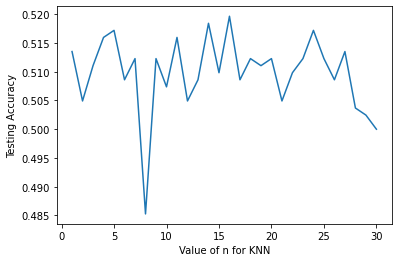

In [275]:
k_range = range(1, 31)

# Train KNN models for each value of n
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    scores.append(score)

# Plot the accuracy scores for each value of n
plt.plot(k_range, scores)
plt.xlabel('Value of n for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

In [276]:
neigh = KNeighborsClassifier(n_neighbors=23)
rf = RandomForestClassifier(class_weight = 'balanced')
xgmodel = XGBClassifier(class_weight = 'balanced')

In [277]:
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_train)
print(metrics.classification_report(y_pred, y_train))


              precision    recall  f1-score   support

           0       0.57      0.54      0.56      1039
           1       0.20      0.59      0.30       267
           2       0.78      0.60      0.68      1950

    accuracy                           0.58      3256
   macro avg       0.52      0.58      0.51      3256
weighted avg       0.67      0.58      0.61      3256



Classification Report has following Parameters:

**Precision**: It is the ratio of correctly predicted positive observations to the total predicted positive observations. Precision measures how accurate the positive predictions are.

**Recall**: It is the ratio of correctly predicted positive observations to the all observations in actual class. Recall measures how many actual positive observations are correctly captured by the model.

**F1-Score:** It is the weighted average of precision and recall. The F1-score provides a balanced view of the model's performance by considering both precision and recall.

**Support:** It is the number of observations for each class.


In [278]:
knn_model = neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print(metrics.classification_report(y_pred, y_test))
accuracy = accuracy_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.51      0.49      0.50       263
           1       0.21      0.61      0.31        76
           2       0.72      0.51      0.60       475

    accuracy                           0.51       814
   macro avg       0.48      0.53      0.47       814
weighted avg       0.60      0.51      0.54       814



## Variable Importance

#### **Q8. Which predictor variables are the most important?**

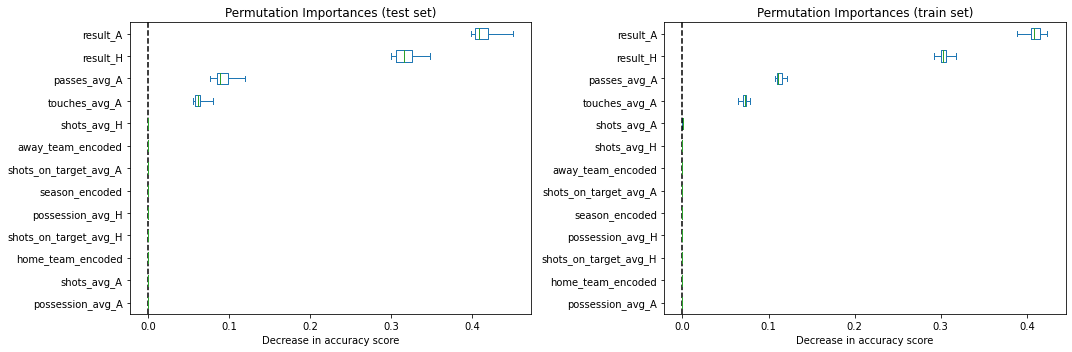

In [279]:
from sklearn.inspection import permutation_importance
from matplotlib.pyplot import figure

# Calculate permutation importance for test data 
result_test = permutation_importance(clf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(result_test.importances[sorted_importances_idx_test].T, columns=X.columns[sorted_importances_idx_test],)

# Calculate permutation importance for training data 
result_train = permutation_importance(clf, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(result_train.importances[sorted_importances_idx_train].T,columns=X.columns[sorted_importances_idx_train],)


f, axs = plt.subplots(1,2,figsize=(15,5))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()

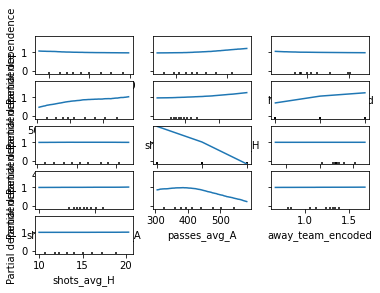

In [285]:
from sklearn.inspection import plot_partial_dependence

features = list(X.columns)
plot_partial_dependence(clf, X_test, features, target = clf.classes_[0])
plt.show()